# Laser-Ablation Inductively Coupled Mass Spectroscopy Data Analysis
I have written a program to process LA-ICPMS data and convert it useable results in my reserach. The instrument outputs a time series of counts from the spectrometer for each isotope of interest. We then need to process this data to convert it into concentrations and data we can analyze. Currently we use software the runs Excel macros to process the raw data for standards and unknowns into concentrations. 
Here I will process the data with the hope of starting to build a tool that can streamline our analysis. I am looking for zonation in olivine grains that are found in peridotite xenoliths. I am comparing these grains to olivine phenocrysts found in the magma that carried the xenolith to the surface. I expect to find little to no chemical zonation in the xenolith olivines because I am assuming that they have not had enough time to diffusively equilibrate with the magma. I expect to find zonation in the phenocryst olivines grown in the magma.   


The methods for calibration follow those used by Jeol Spark's LAsy-Boy excel program

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import copy 
%matplotlib inline


To read in the data I will make a multiindex pandas table so that I can index by the sample name and by the aquisition time. 

In [2]:
df = pd.read_csv('GCB1AHT.csv',  index_col = ['SampleLabel', 'Time'],)
df.head()

7Li       26Mg       27Al       29Si       31P  \
SampleLabel Time                                                          
bir-1       0.0     1100.042  34040.508  21916.799  64947.300  3400.405   
            643.0   1500.079  41560.366  26524.602  70171.921  3500.429   
            1033.0   700.017  36546.688  27526.494  62235.268  3600.454   
            1423.0  1800.113  39755.240  25723.138  67860.796  3400.405   
            1813.0  1500.079  42061.831  28829.060  69870.449  3300.381   

                        43Ca      45Sc      48Ti      51V       52Cr  \
SampleLabel Time                                                       
bir-1       0.0      900.028  4200.618  2000.140    0.000  43766.942   
            643.0   1300.059  4400.678  2400.202    0.000  47478.767   
            1033.0  1600.090  3600.454  2300.185  300.003  46876.784   
            1423.0  1200.050  3100.336  1100.042  700.017  46575.802   
            1813.0  1400.069  4400.678  2700.255  400.006  46475.476   

                        55Mn       57Fe      59Co       60Ni      63Cu  \
SampleLabel Time                                                         
bir-1       0.0     3100.336  22217.263  3000.315  21416.041  1900.126   
            643.0   5200.947  21716.494  2800.274  16409.419  1100.042   
            1033.0  3500.429  24320.685  3400.405  19713.593  1900.126   
            1423.0  3900.532  21315.891  2900.294  18712.247   400.006   
            1813.0  3800.506  21015.446  2100.154  17110.240   900.028   

                       66Zn     88Sr      89Y     90Zr  
SampleLabel Time                                        
bir-1       0.0     200.001  300.003  200.001    0.000  
            643.0   200.001    0.000  100.000  100.000  
            1033.0    0.000    0.000  100.000  400.006  
            1423.0    0.000    0.000  200.001  100.000  
            1813.0  100.000  300.003  200.001  100.000

In [3]:
# Creating a list of the samples in this dataset
sample_names = df.index.levels[0]

In [4]:
sample_names

Index(['GCB 1AHT ol1', 'GCB 1AHT ol1_part 2', 'GCB 1AHT ol6', 'GCB Scoria ol6',
       'bhvo-1', 'bir-1', 'sc ol 1'],
      dtype='object', name='SampleLabel')

In [5]:
df.loc['bir-1'].head()

,7Li,26Mg,27Al,29Si,31P,43Ca,45Sc,48Ti,51V,52Cr,55Mn,57Fe,59Co,60Ni,63Cu,66Zn,88Sr,89Y,90Zr
Time,,,,,,,,,,,,,,,,,,,
0.0,1100.042,34040.508,21916.799,64947.300,3400.405,900.028,4200.618,2000.140,0.000,43766.942,3100.336,22217.263,3000.315,21416.041,1900.126,200.001,300.003,200.001,0.000
643.0,1500.079,41560.366,26524.602,70171.921,3500.429,1300.059,4400.678,2400.202,0.000,47478.767,5200.947,21716.494,2800.274,16409.419,1100.042,200.001,0.000,100.000,100.000
1033.0,700.017,36546.688,27526.494,62235.268,3600.454,1600.090,3600.454,2300.185,300.003,46876.784,3500.429,24320.685,3400.405,19713.593,1900.126,0.000,0.000,100.000,400.006
1423.0,1800.113,39755.240,25723.138,67860.796,3400.405,1200.050,3100.336,1100.042,700.017,46575.802,3900.532,21315.891,2900.294,18712.247,400.006,0.000,0.000,200.001,100.000
1813.0,1500.079,42061.831,28829.060,69870.449,3300.381,1400.069,4400.678,2700.255,400.006,46475.476,3800.506,21015.446,2100.154,17110.240,900.028,100.000,300.003,200.001,100.000


I need to load in the standards and their known concentrations. I will then load a key to convert the mass number given in raw data file the element name used in the final results 

In [6]:

Stand_conc = pd.read_csv('LAICPMS Standard Values.csv',  index_col = "Mass #", )
Stand_conc.head()


,Elem Symbol,Dwell Time,Unnamed: 3,BCR-2g,BHVO-2g,BIR-1g
Mass #,,,,,,
7,Li,NaN,NaN,10.085,4.60,3.100
9,Be,NaN,NaN,2.916,1.20,0.098
11,B,NaN,NaN,3.000,2.50,0.330
23,Na2O%,NaN,NaN,3.160,2.22,1.820
24,MgO%,NaN,NaN,3.590,7.23,9.680


In [7]:
Stand_conc = Stand_conc.drop(columns =["Dwell Time","Unnamed: 3"])

In [8]:
Element_Mass = pd.read_csv('LAICPMS_Element_Mass_ID.csv', index_col= 'Number of Masses')

In [9]:
Element_Mass = Element_Mass.drop(columns=['Unnamed: 3', 'Unnamed: 4'])
Element_Mass.head()

,Mass Numbers,Corresponding Element Symbols
Number of Masses,,
7Li,7.0,Li
23Na,23.0,Na
26Mg,26.0,Mg
27Al,27.0,Al
29Si,29.0,Si


In [10]:
p =Element_Mass.loc[Element_Mass['Corresponding Element Symbols'] == 'Li'].index.values[0]
p

'7Li'

# Identifying Peaks and Backgrounds
The first step in analysis is to identify where the signal begins and subtract the backround counts from the measument. This is best done on a log scale comparing multiple elements.


In [11]:
# Make a database of peaks

peaks = pd.read_csv('Peaks_backup', index_col='SampleLabel')


#peaks = pd.DataFrame(index= sample_names, columns = ['Window name','Bk_min', 'Bk_max','Pk_min','Pk_max'])

In [12]:
# plotting function for raw data


def plot_counts(el_symbols, sample_name ,Dataframe = df, 
                mass_ID = Element_Mass, output=peaks, 
                new_peaks = False):
    data = Dataframe.loc[sample_name]
    fig, ax = plt.subplots(figsize = (12,6))
    for element in el_symbols:
        try:
            name = Element_Mass.loc[Element_Mass['Corresponding Element Symbols'] == element].index.values[0]
            #data[name].plot(logy = True, ax = ax)
            plt.semilogy(data[name], label = name)
        except:
                pass
    plt.legend()
    ax.set_title(sample_name)
    ax.set_ylabel('Counts')
    plt.grid(which = "both", axis = "x", linestyle="-")
    plt.show()
    if new_peaks == True:
        out = output.loc[sample_name]
        out['Bk_min'], out['Bk_max'] = input('Background: min, max').strip('][ ').split(',')
        out['Pk_min'], out['Pk_max'] = input('Peak: min, max').strip('][ ').split(',')
        peaks.to_csv('Peaks_backup', header =True, index =True)
    
    

In [13]:
peaks.to_csv('Peaks_backup_1', header =True, index =True)

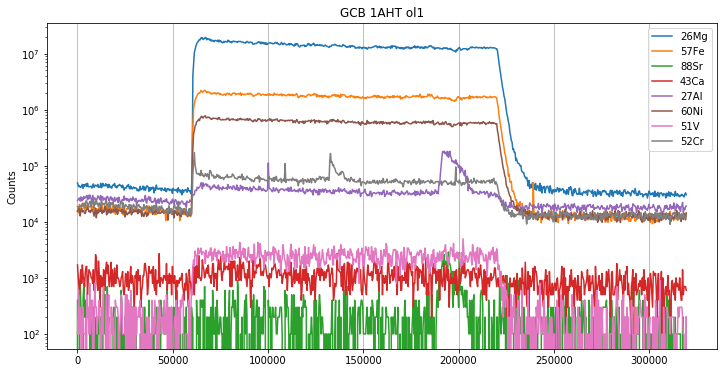

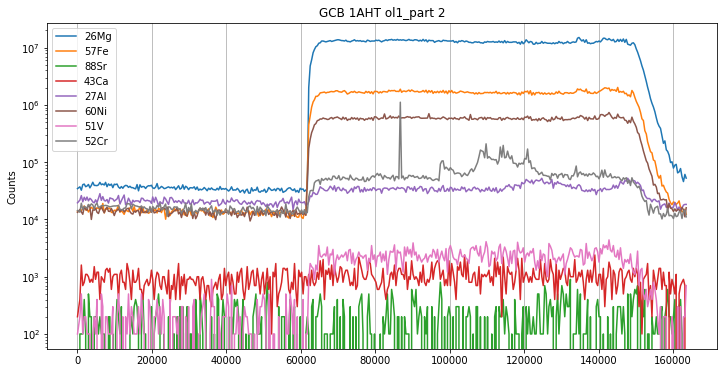

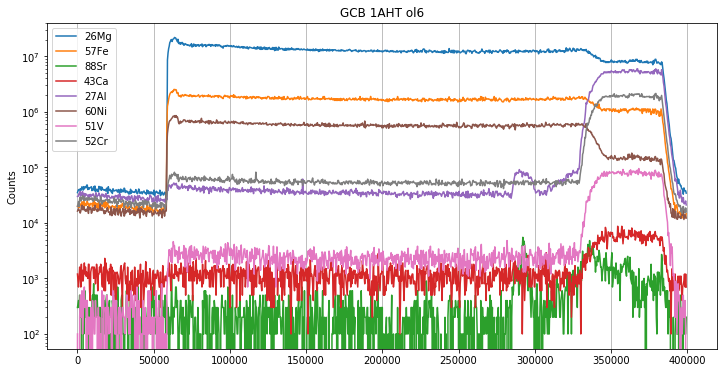

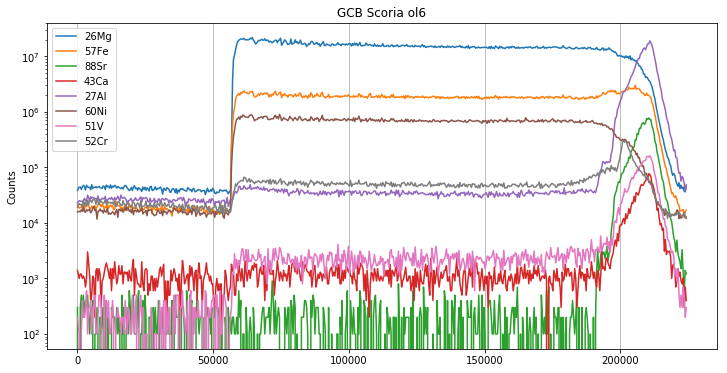

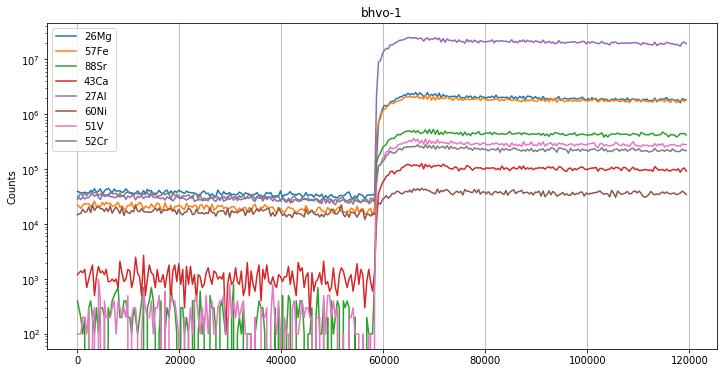

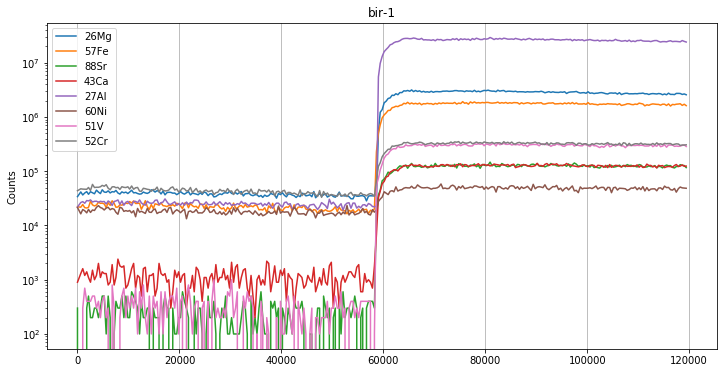

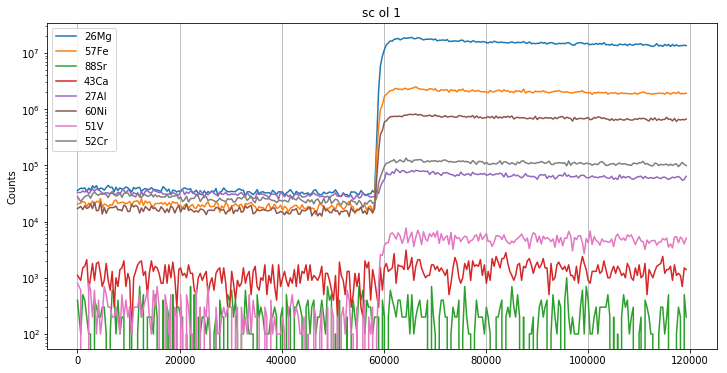

In [14]:
for name in sample_names:
    plot_counts(['Mg','Fe','Sr','Ca', 'Al', 'Ni', 'V', 'Cr'], name) #,new_peaks=True)


From the plots above we can identify the time steps for the "peaks" when the laser was ablating the sample and the background signal collected before the laser hit the sample. 
We can also identify where the includions in the sample from spikes in signal from elements we wouldnt expect to be in high abundance such as Ca, Sr, and Al. 

In the future I would like to have an interactive feature to help process many more spectra and make a estimates of the peak and background regions. 
Currently you can set the new_peaks in plot_counts to True if you want to manually input peaks

In [15]:
Avg_counts = pd.DataFrame(index= sample_names, columns = df.columns)

In [16]:
for idx, row in peaks.iterrows():
    Pk_avg = df.loc[idx][row['Pk_min']:row['Pk_max']].mean(axis = 0)
    Bk_avg = df.loc[idx][row['Bk_min']:row['Bk_max']].mean(axis = 0)
    Avg_counts.loc[idx]=(Pk_avg - Bk_avg).transpose()


In [17]:
Avg_counts

,7Li,26Mg,27Al,29Si,31P,43Ca,45Sc,48Ti,51V,52Cr,55Mn,57Fe,59Co,60Ni,63Cu,66Zn,88Sr,89Y,90Zr
SampleLabel,,,,,,,,,,,,,,,,,,,
GCB 1AHT ol1,141.268,1.56732e+07,14825,2.02481e+06,1240.09,245.474,2222.97,7660.19,2372.97,41211.2,1.35385e+06,1.85984e+06,147002,643411,1122.52,12784.3,48.2525,6.29373,-5.59465
GCB 1AHT ol1_part 2,242.191,1.32355e+07,13262.2,1.77597e+06,1973.97,228.351,2092.02,6737.47,2149.68,54095.2,1.20277e+06,1.68372e+06,133177,574044,927.146,11233.2,17.5644,17.0514,36.6671
GCB 1AHT ol6,19.2113,1.3556e+07,7141.13,1.78373e+06,585.966,22.6236,1688.25,7001.61,2184.04,31427.8,1.26257e+06,1.74061e+06,136612,581330,184.605,11201.2,-54.6001,15.4379,4.22877
GCB Scoria ol6,236.081,1.60991e+07,8932.81,2.07863e+06,587.358,86.8381,1910.3,3481.9,1980.68,29124.5,1.34284e+06,1.88184e+06,153693,699340,617.742,10587.4,-31.3576,-6.69697,-6.01805
bhvo-1,617.115,1.96252e+06,2.09669e+07,2.01997e+06,56885.9,103412,23351.6,1.11534e+07,288353,199862,1.37707e+06,1.81913e+06,38246.7,20629.9,54245.5,19900.7,442843,22504.1,80883.7
bir-1,316.601,2.84097e+06,2.65453e+07,2.00014e+06,3953.9,126254,34895.9,4.19123e+06,302894,282090,1.45477e+06,1.74979e+06,47078.6,31255.4,53477.8,13862.2,126140,15221.8,7377.01
sc ol 1,161.478,1.52732e+07,35190.6,2.06671e+06,740.779,377.376,2529.17,13642.4,4687.58,85071.7,1.46267e+06,2.03645e+06,159351,689384,400.1,13461.7,9.23091,31.8185,-25.8745


# Calibrating Standards
Now that we have the average counts for each peak without the background we can create a calibration curve for each element usinf the two standards: BHVO and BIR.

First we will identify the known concnetrations from our reference file then we can make linear regressions to build a calibration curve. 

In [18]:
Stand_conc = Stand_conc.rename(index= str, columns = {'BHVO-2g': 'bhvo-1', 'BIR-1g': 'bir-1'})

In [19]:
Element_Mass.head()

,Mass Numbers,Corresponding Element Symbols
Number of Masses,,
7Li,7.0,Li
23Na,23.0,Na
26Mg,26.0,Mg
27Al,27.0,Al
29Si,29.0,Si


In [20]:
Normalized_counts= Avg_counts.divide(Avg_counts['26Mg'], axis = 'rows')

In [21]:
std_counts = Normalized_counts.loc['bhvo-1':'bir-1']
std_key = Element_Mass['Mass Numbers'].loc[std_counts.columns]
std_key.loc['48Ti'] = 48 
#std_conc = Stand_conc.loc[]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Format the known concentrations of the standards so it can be used with the measured counts


In [22]:
std_conc_final = copy.copy(std_counts)
Conc_Symbol = pd.Series(index= std_conc_final.columns, name= "Conc_Symbol")
Conc_type = pd.Series(index= std_conc_final.columns, name= "Conc_Type")


for idx, row in std_counts.iterrows():
    for col in row.index:
        mass_num = int(std_key.loc[col])
        std_conc_final.loc[idx][col] =  Stand_conc.loc[str(mass_num)][idx]
        Conc_Symbol[col] = Stand_conc.loc[str(mass_num)]["Elem Symbol"]
        if "%" in Stand_conc.loc[str(mass_num)]["Elem Symbol"]:
            Conc_type[col] = "wt%"
        else:
            Conc_type[col] = "ppm"

std_conc_final = std_conc_final.append(Conc_Symbol)
std_conc_final = std_conc_final.append(Conc_type)


NameError: name 'std_conc_final' is not defined

In [ ]:
std_conc_final

In [ ]:


def slopefit(x,slope):
    return slope * x

cal_slopes = pd.DataFrame( columns=['Slope', 'Error'], index = std_counts.columns)
for col in std_counts.columns:
    y = std_counts[col].values.astype('float64') * std_conc_final['26Mg'][0:2].values.astype('float64')
    x = std_conc_final[col][0:2].values.astype('float64')
    popt, pcov = opt.curve_fit(slopefit, x, y)
    cal_slopes.loc[col]['Slope'] = popt[0]
    cal_slopes.loc[col]['Error'] = pcov[0]

In [ ]:
cal_slopes

In [ ]:
slopefit(np.array([0,3]),3)

In [ ]:
for element in cal_slopes.index:
    fig, ax = plt.subplots()
    x = std_conc_final[element][0:2].values.astype('float64')
    y = std_counts[element].values.astype('float64') * std_conc_final['26Mg'][0:2].values.astype('float64')
    linex = np.array([0, x.max()])
    ax.plot(linex, slopefit(linex,cal_slopes.loc[element].Slope) )
    
    ax.scatter(x,  y, color = 'r' )
    slope = cal_slopes.loc[element].Slope
    error = cal_slopes.loc[element].Error
    
    ax.annotate(f"$\ Y = {float(slope):.3g}(\pm{float(error):.1g})X $", xy = (x.max()*0.27 , y.max()*0.7))
    
    ax.set_ylabel('Interal Standard * Normalized Counts ' + element)
    ax.set_xlabel('Concentration')
    ax.set_title(element + ' Calibration Slope')

# Concentration
Finally we are ready to calculate the concnetration of each element for each sample.
Now we will multiply the normalized counts for each element by our internal standard which should be about 50 wt% MgO for these olivines. Then we can divide that by the calibration slopes to determine a concentration. 

In [ ]:
Concentrations = Normalized_counts * 50 / cal_slopes['Slope'].transpose()
Concentrations = Concentrations.drop( index = ['bhvo-1', 'bir-1'])

In [ ]:
Concentrations

In [ ]:
# Measure of the amount mols of Mg relative to the sum of Fe and Mg
Concentrations['Mg#'] = (Concentrations['26Mg']/40.3044 / (Concentrations['26Mg']/40.3044 + Concentrations['57Fe']/71.844))
Concentrations = Concentrations.astype('float64')
Concentrations['Mg#']

In [ ]:
# We see a slight negative trend in Nickle concentration with Magnesium Number
Concentrations.plot.scatter(x = 'Mg#', y = '60Ni')

In [ ]:
# Additionally we see a similar negative trend between Cr and Mg# in the mineral. 
Concentrations.plot.scatter(x = 'Mg#', y = '52Cr')


# Ratio plots
These ratio plots allow me to see zonation in the samples

In [ ]:
fig, ax = plt.subplots(figsize= (12,8))
smoothed = (df.loc['GCB 1AHT ol6']['57Fe'].divide(df.loc['GCB 1AHT ol6']['26Mg'])).rolling(20).mean()
ax = smoothed.plot()
ax.set_ylim(0.1,0.15)
ax.set_xlim(50000, 400000)
ax.set_ylabel( "Ratio Counts Fe/ Counts Mg")
ax.set_title('Xenolith Olivine 6 Zoning')

In [ ]:
fig, ax = plt.subplots(figsize= (12,8))
smoothed = (df.loc['GCB 1AHT ol6']['27Al'].divide(df.loc['GCB 1AHT ol6']['26Mg'])).rolling(20).mean()
ax = smoothed.plot()
ax.set_ylim(0.002,0.008)
ax.set_xlim(50000, 400000)
ax.set_ylabel( "Ratio Counts Al / Counts Mg")
ax.set_title('Xenolith Olivine 6 Zoning')

In [ ]:
fig, ax = plt.subplots(figsize= (12,8))
ax= (df.loc['GCB Scoria ol6']['57Fe'].divide(df.loc['GCB Scoria ol6']['26Mg'])).rolling(20).mean().plot()
ax.set_ylim(0.1,0.15)
ax.set_xlim(50000, 200000)
ax.set_ylabel( "Ratio Counts Fe/ Counts Mg")
ax.set_title('Scoria Olivine Phenocryst 6 Zoning')

These trends show that the olivine phenocryst is zoned towards the rim with respect to iron and magnesium. The xenolith olivine shows periodic zoning which could be related to micro_scale inclsuions of the mineral spinel. Plotting Al vs mg allow me to identify where the variation Fe/Mg zoning is caused by other phases such as the large peak observed  near 300000 in to the timeseries. 

# Conclusion
This project was more technically challenging than I had expected. The different formats for the data necessary to construct the calibration curves was a big challenge. I think I may try to do more clean up and labeling of the original csv files to standardize the element names before the analysis. 

This tool requires more work to make it useful for our research. I think it will be worth it since it will help with error analysis and allow me to easily implement other calibration schemes. 
Future work would be to add more internal standards to the code to improve the accuracy of the concnetrations. This is something that would be beyond the scope of the previous Excel software we are currently using. 

I would also like to make the peak and background selection more interactive and allow for selecting multiple regions of the same sample for multiple concentration measurements across the same grain. 

I could also write some simple plotting functions to streamline common plots. 
